# Red Wine Quality Classifier
## Introduction:
Red wine is a popular type of wine made from dark-colored grapes, known for its rich flavor and complexity. Wine quality is typically evaluated based on factors such as aroma, taste, and acidity,etc. We use this dataset to address “how can a business predict the quality of wine they produce based on its chemical composition by using this dataset”.


There are 12 input variables in this dataset based on physicochemical tests: 

        1 - fixed acidity ((grams of tartaric acid)/dm3): refers to the non-volatile acids present in wine, which do not evaporate easily.
        2 - volatile acidity ((grams of acetic acid)/dm3): refers to the amount of acetic acid in wine, which can lead to an unpleasant vinegar taste if present in excessive amounts.       
        3 - citric acid (g/dm3): is found in small quantities in wine and can add a sense of freshness and flavor to it.
        4 - residual sugar (g/dm3): refers to the amount of sugar left over after the fermentation process is complete,wines with more than 45 grams per liter are considered sweet. 
        5 - chlorides(In grams of sodium chloride per cubic decimetre): refer to the amount of salt present in wine.       
        6 - free sulfur dioxide (mg/dm3): helps prevent microbial growth and wine oxidation. 
        7 - total sulfur dioxide (mg/dm3): refers to the amount of both free and bound forms of SO2. Concentrations over 50 ppm can be detected in the taste and aroma of wine.
        8 - density (g/cm3): Density of wine is close to that of water and depends on its alcohol and sugar content.
        9 - pH :measures the acidity or basicity of wine on a scale from 0 to 14.
        10 - sulphates ((grams of potassium sulphate)/dm3): are an additive in wine that can contribute to sulfur dioxide gas levels, acting as an antimicrobial and antioxidant. 
        11 - alcohol: percentage of alcohol content is an important factor to consider when assessing wine quality. 
        Output variable (based on sensory rating): 
        12 - quality (between 0-10): Sensory rating by human experts.
 
## Methods:
First split the dataset into training and dataset. Use training set to preprocess and create model specification. Next use cross-validation on training set to determine the best K nearest-neighbor value to use when creating a classifier, which ensures the highest prediction accuracy. Lastly, use the tuned classifier with K value that gives the highest prediction accuracy on the testing set to predict the quality of the newly introduced wine.

The columns we will use when classifying will be pH, alcohol, sulphates, residual sugar, volatile acidity, and quality. We chose to use these columns because these qualities will significantly ater the human assessed quality of a new wine.  


Visualize the result with a line plot that includes the different wines numbered 1 to n, where n is the total number of wines used (ordered, distinct numerical values), on the x-axis and their ratings from 0-10 on the y-axis (distinct numerical values). 
## Expected outcomes and significance:
In this research, we expected to find which physicochemical properties make high-quality red wine, and what chemical compositions are required for high-quality red wine. Once we know what physicochemical properties contribute to a good quality score, businesses will be able to use this information to help them produce higher-quality wine. Based on our findings, we came up with two questions that can be worked on in the future:
“What role does each chemical composition play in making high-quality red wine?”
“What relationships between these properties contribute to making high-quality red wine?”

### Citation
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

## Preliminary exploratory data analysis: 

In [61]:
install.packages("themis")
library(repr)
library(tidyverse)
library(tidymodels)
library(dplyr)
library(themis)

options(repr.matrix.max.rows = 6)

wine_quality <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", delim = ";")
colnames(wine_quality) <- make.names(colnames(wine_quality))
wine_quality

wine_quality <- select(wine_quality, volatile.acidity, pH, alcohol, sulphates, residual.sugar, quality) |>
                 mutate(across(1:6, as.numeric)) |>
                 mutate(new_quality = case_when(
                             quality <= 4 ~ "bad",
                             between(quality, 5, 6) ~ "moderate",
                             quality >= 7 ~ "good",
                             TRUE ~ "")) |>
                 arrange(quality)
wine_quality

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.3,0.510,0.13,2.3,0.076,29,40,0.99574,3.42,0.75,11.0,6
5.9,0.645,0.12,2.0,0.075,32,44,0.99547,3.57,0.71,10.2,5
6.0,0.310,0.47,3.6,0.067,18,42,0.99549,3.39,0.66,11.0,6


volatile.acidity,pH,alcohol,sulphates,residual.sugar,quality,new_quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.580,3.25,9.0,0.57,2.20,3,bad
0.610,3.16,8.4,0.63,2.10,3,bad
1.185,3.63,10.7,0.54,4.25,3,bad
⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.33,3.23,10.0,1.10,1.7,8,good
0.38,3.23,11.3,0.76,2.0,8,good
0.36,3.24,11.4,0.70,1.8,8,good


### Explanations 

Summary table including mean column values, grouped by quality.
Plot of number of observations for each quality of wine.

Scatter plots of the distribution for each predictor, showing where the data lies for each wine quality. This will help determine what values for each physiochemical property contribute to a better quality wine.

volatile.acidity,pH,alcohol,sulphates,residual.sugar,quality,new_quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
0.580,3.25,9.0,0.57,2.20,3,bad
0.610,3.16,8.4,0.63,2.10,3,bad
1.185,3.63,10.7,0.54,4.25,3,bad
⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.33,3.23,10.0,1.10,1.7,8,good
0.38,3.23,11.3,0.76,2.0,8,good
0.36,3.24,11.4,0.70,1.8,8,good


new_quality,mean_pH,mean_acidity,mean_alcohol,mean_sulphates,mean_sugar
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bad,3.384127,0.7242063,10.21587,0.5922222,2.684921
good,3.288802,0.4055300,11.51805,0.7434562,2.708756
moderate,3.311296,0.5385595,10.25272,0.6472631,2.503867


quality,observations
<dbl>,<int>
3,10
4,53
5,681
6,638
7,199
8,18


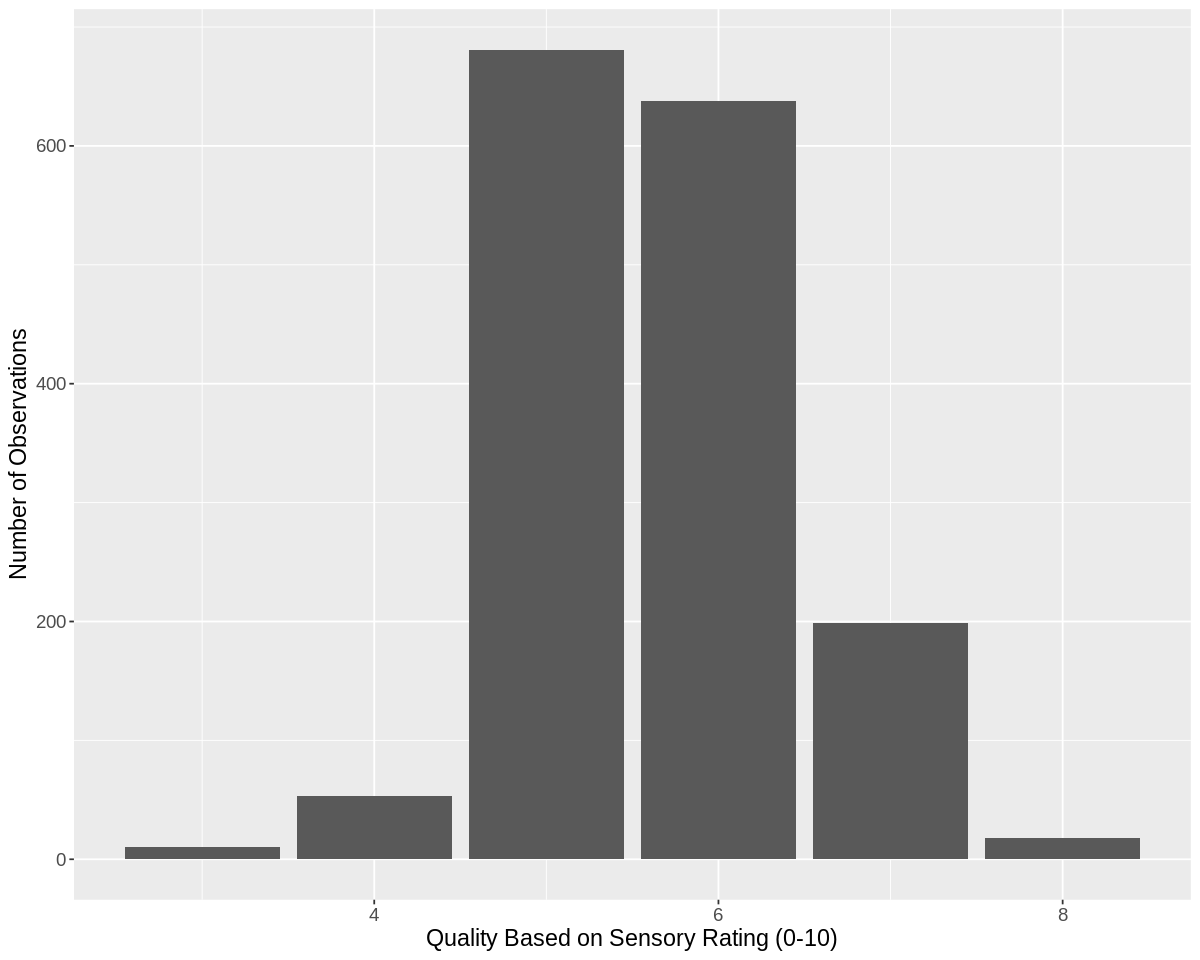

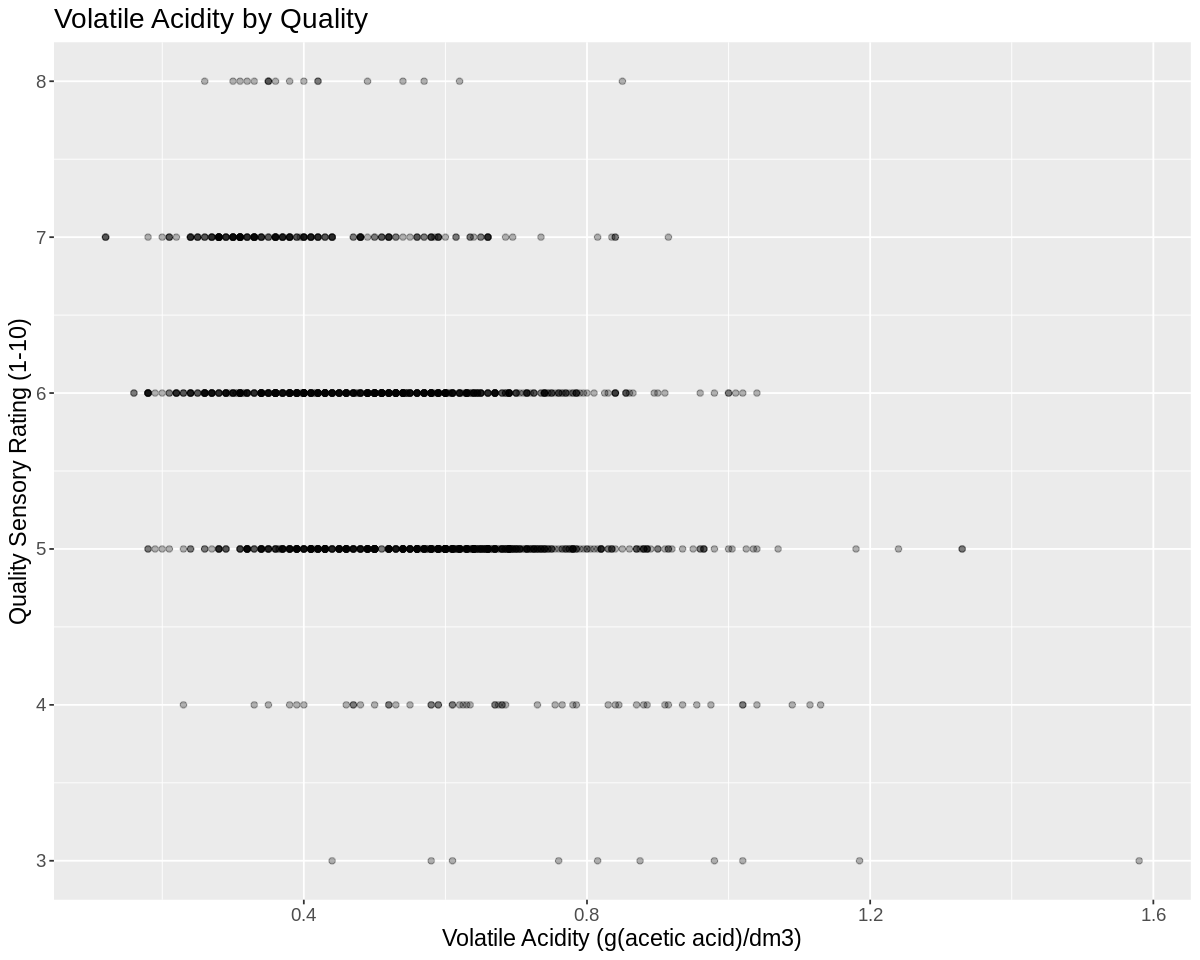

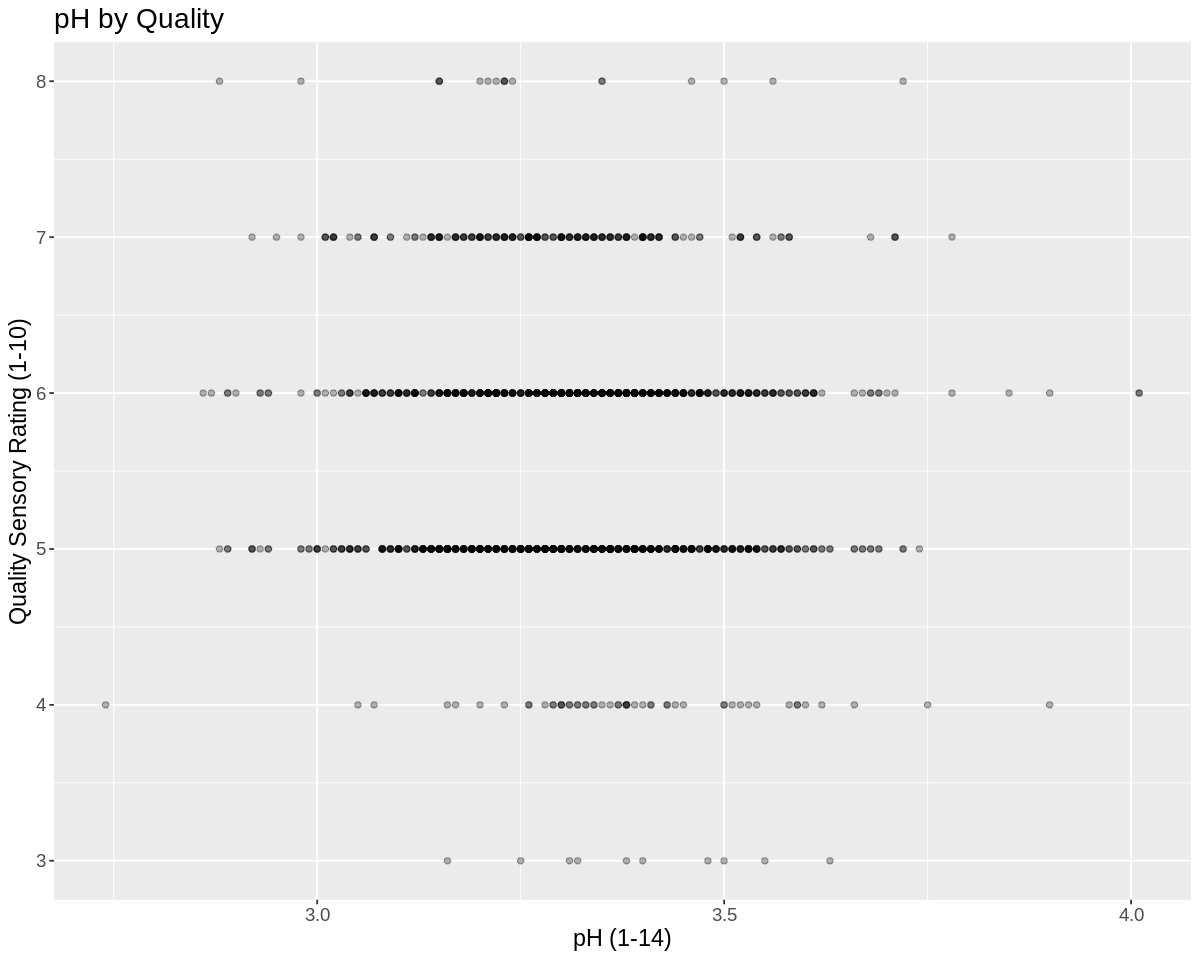

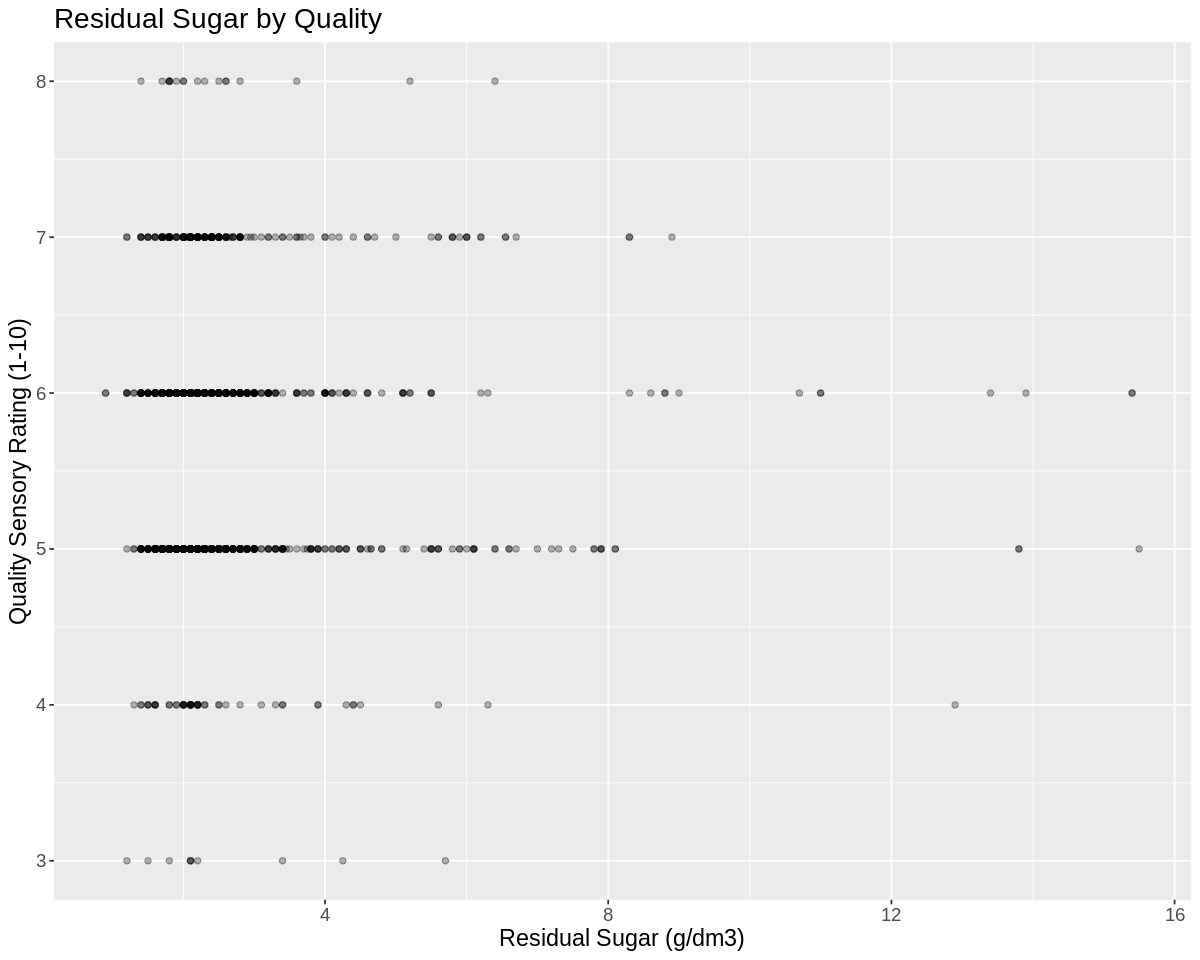

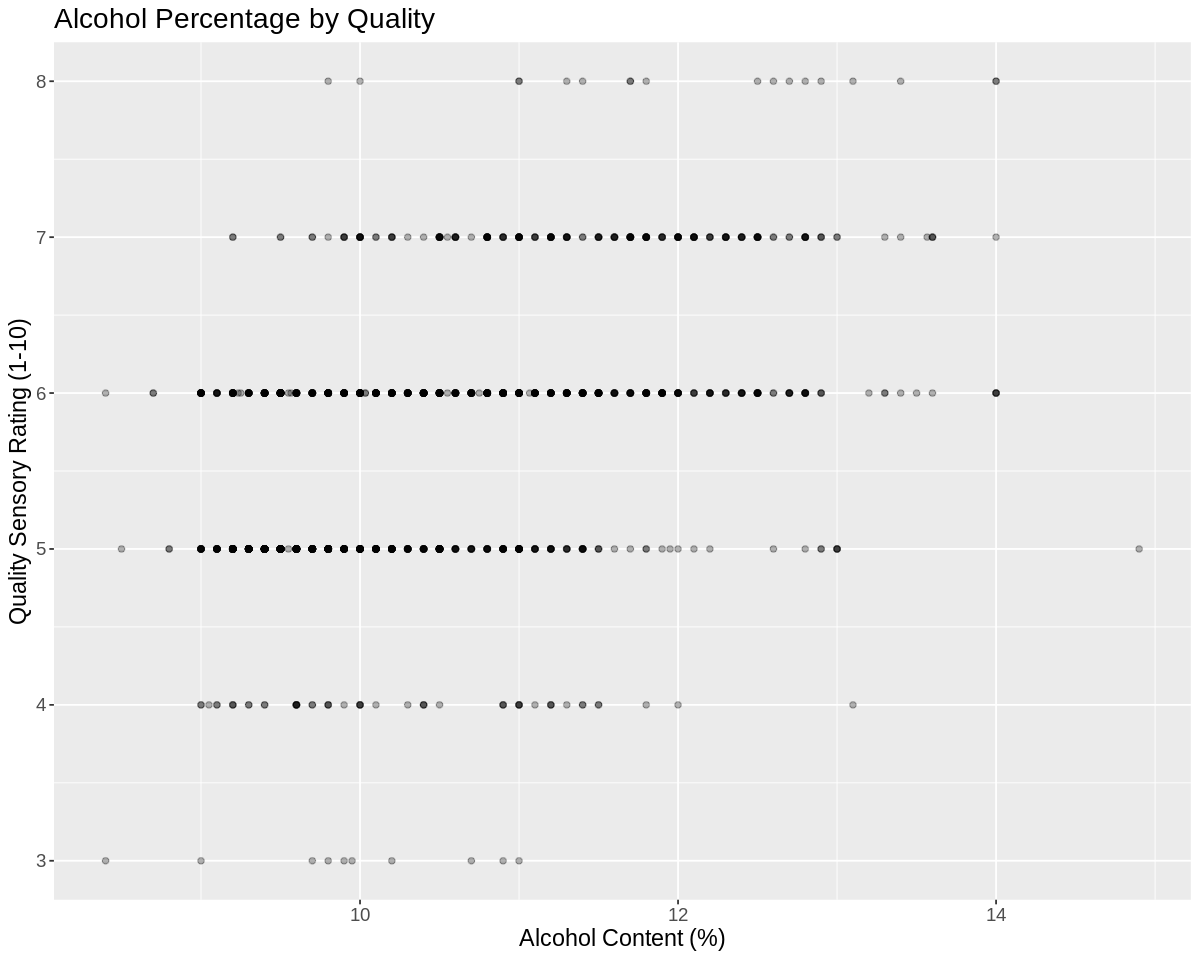

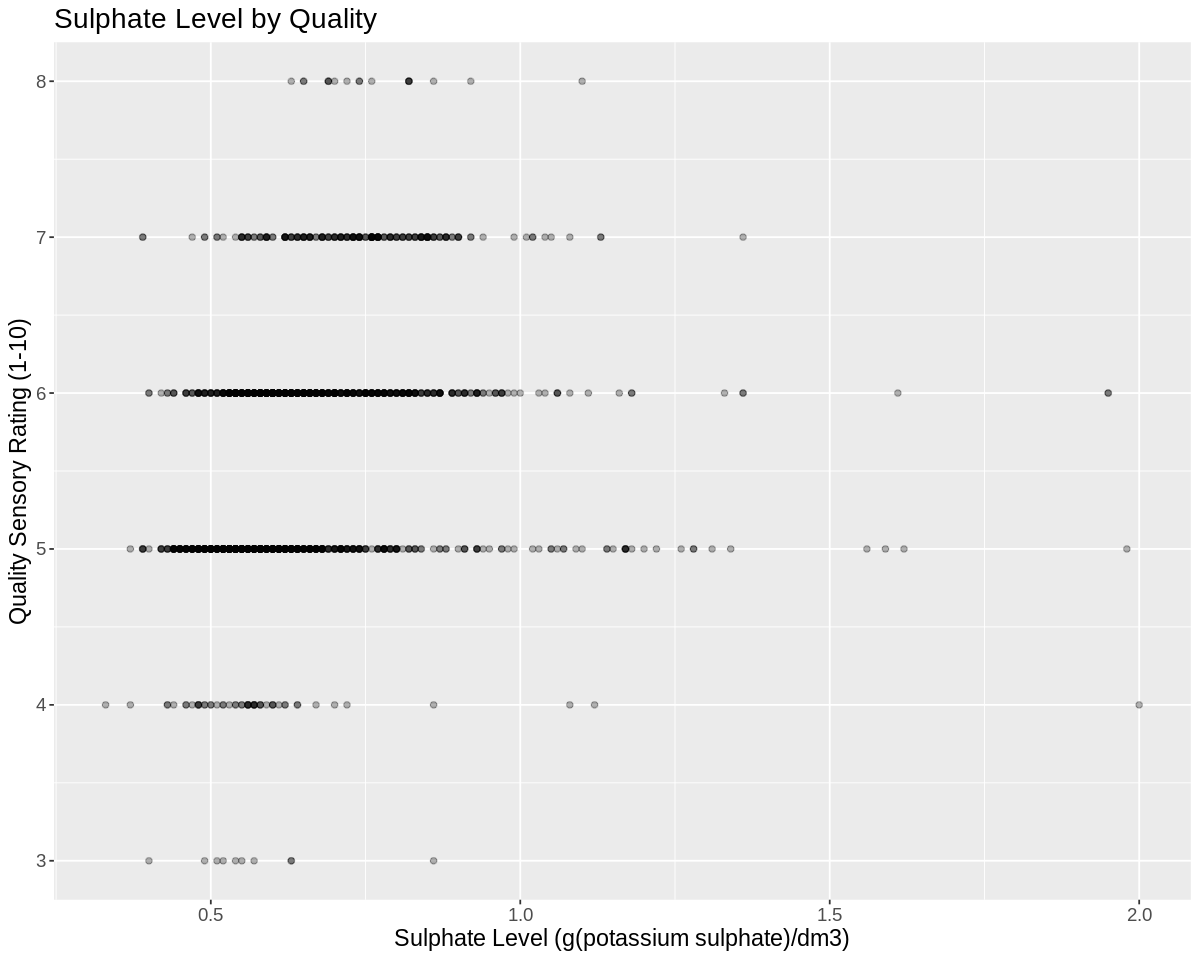

In [43]:
library(RColorBrewer)

wine_quality_factored <- mutate(wine_quality, quality = as.factor(quality))
wine_quality_factored

wine_summary <- group_by(wine_quality, new_quality) |>
                summarize(mean_pH = mean(pH), 
                          mean_acidity = mean(volatile.acidity), 
                          mean_alcohol = mean(alcohol),
                         mean_sulphates = mean(sulphates),
                         mean_sugar = mean(residual.sugar))
wine_summary

wine_grouped <- group_by(wine_quality, quality) |>
                summarize(observations = n())
wine_grouped

options(repr.plot.width = 10, repr.plot.height = 8)
quality_num_plot <- ggplot(wine_grouped, aes(x = quality, y = observations)) +
                        geom_bar(stat = "identity") +
                        xlab("Quality Based on Sensory Rating (0-10)") +
                        ylab("Number of Observations") + 
                        theme(text = element_text(size=14))
quality_num_plot

acidity_quality_plot <- ggplot(wine_quality, aes(x = volatile.acidity, y = quality)) +
                        geom_point(alpha = 0.3) +
                        labs(x = "Volatile Acidity (g(acetic acid)/dm3)", 
                         y = "Quality Sensory Rating (1-10)", 
                         title = "Volatile Acidity by Quality") +
                        theme(text = element_text(size=14))
acidity_quality_plot

pH_quality_plot <- ggplot(wine_quality, aes(x = pH, y = quality)) +
                        geom_point(alpha = 0.3) +
                        labs(x = "pH (1-14)", 
                         y = "Quality Sensory Rating (1-10)", 
                         title = "pH by Quality") +
                        theme(text = element_text(size=14))
pH_quality_plot

sugar_quality_plot <- ggplot(wine_quality, aes(x = residual.sugar, y = quality)) +
                        geom_point(alpha = 0.3) +
                        labs(x = "Residual Sugar (g/dm3)", 
                         y = "Quality Sensory Rating (1-10)", 
                         title = "Residual Sugar by Quality") +
                        theme(text = element_text(size=14))
sugar_quality_plot

alc_quality_plot <- ggplot(wine_quality, aes(x = alcohol, y = quality)) +
                        geom_point(alpha = 0.3) +
                        labs(x = "Alcohol Content (%)", 
                         y = "Quality Sensory Rating (1-10)", 
                         title = "Alcohol Percentage by Quality") +
                        theme(text = element_text(size=14))
alc_quality_plot

sulph_quality_plot <- ggplot(wine_quality, aes(x = sulphates, y = quality)) +
                        geom_point(alpha = 0.3) +
                        labs(x = "Sulphate Level (g(potassium sulphate)/dm3)", 
                         y = "Quality Sensory Rating (1-10)", 
                         title = "Sulphate Level by Quality") +
                        theme(text = element_text(size=14))
sulph_quality_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



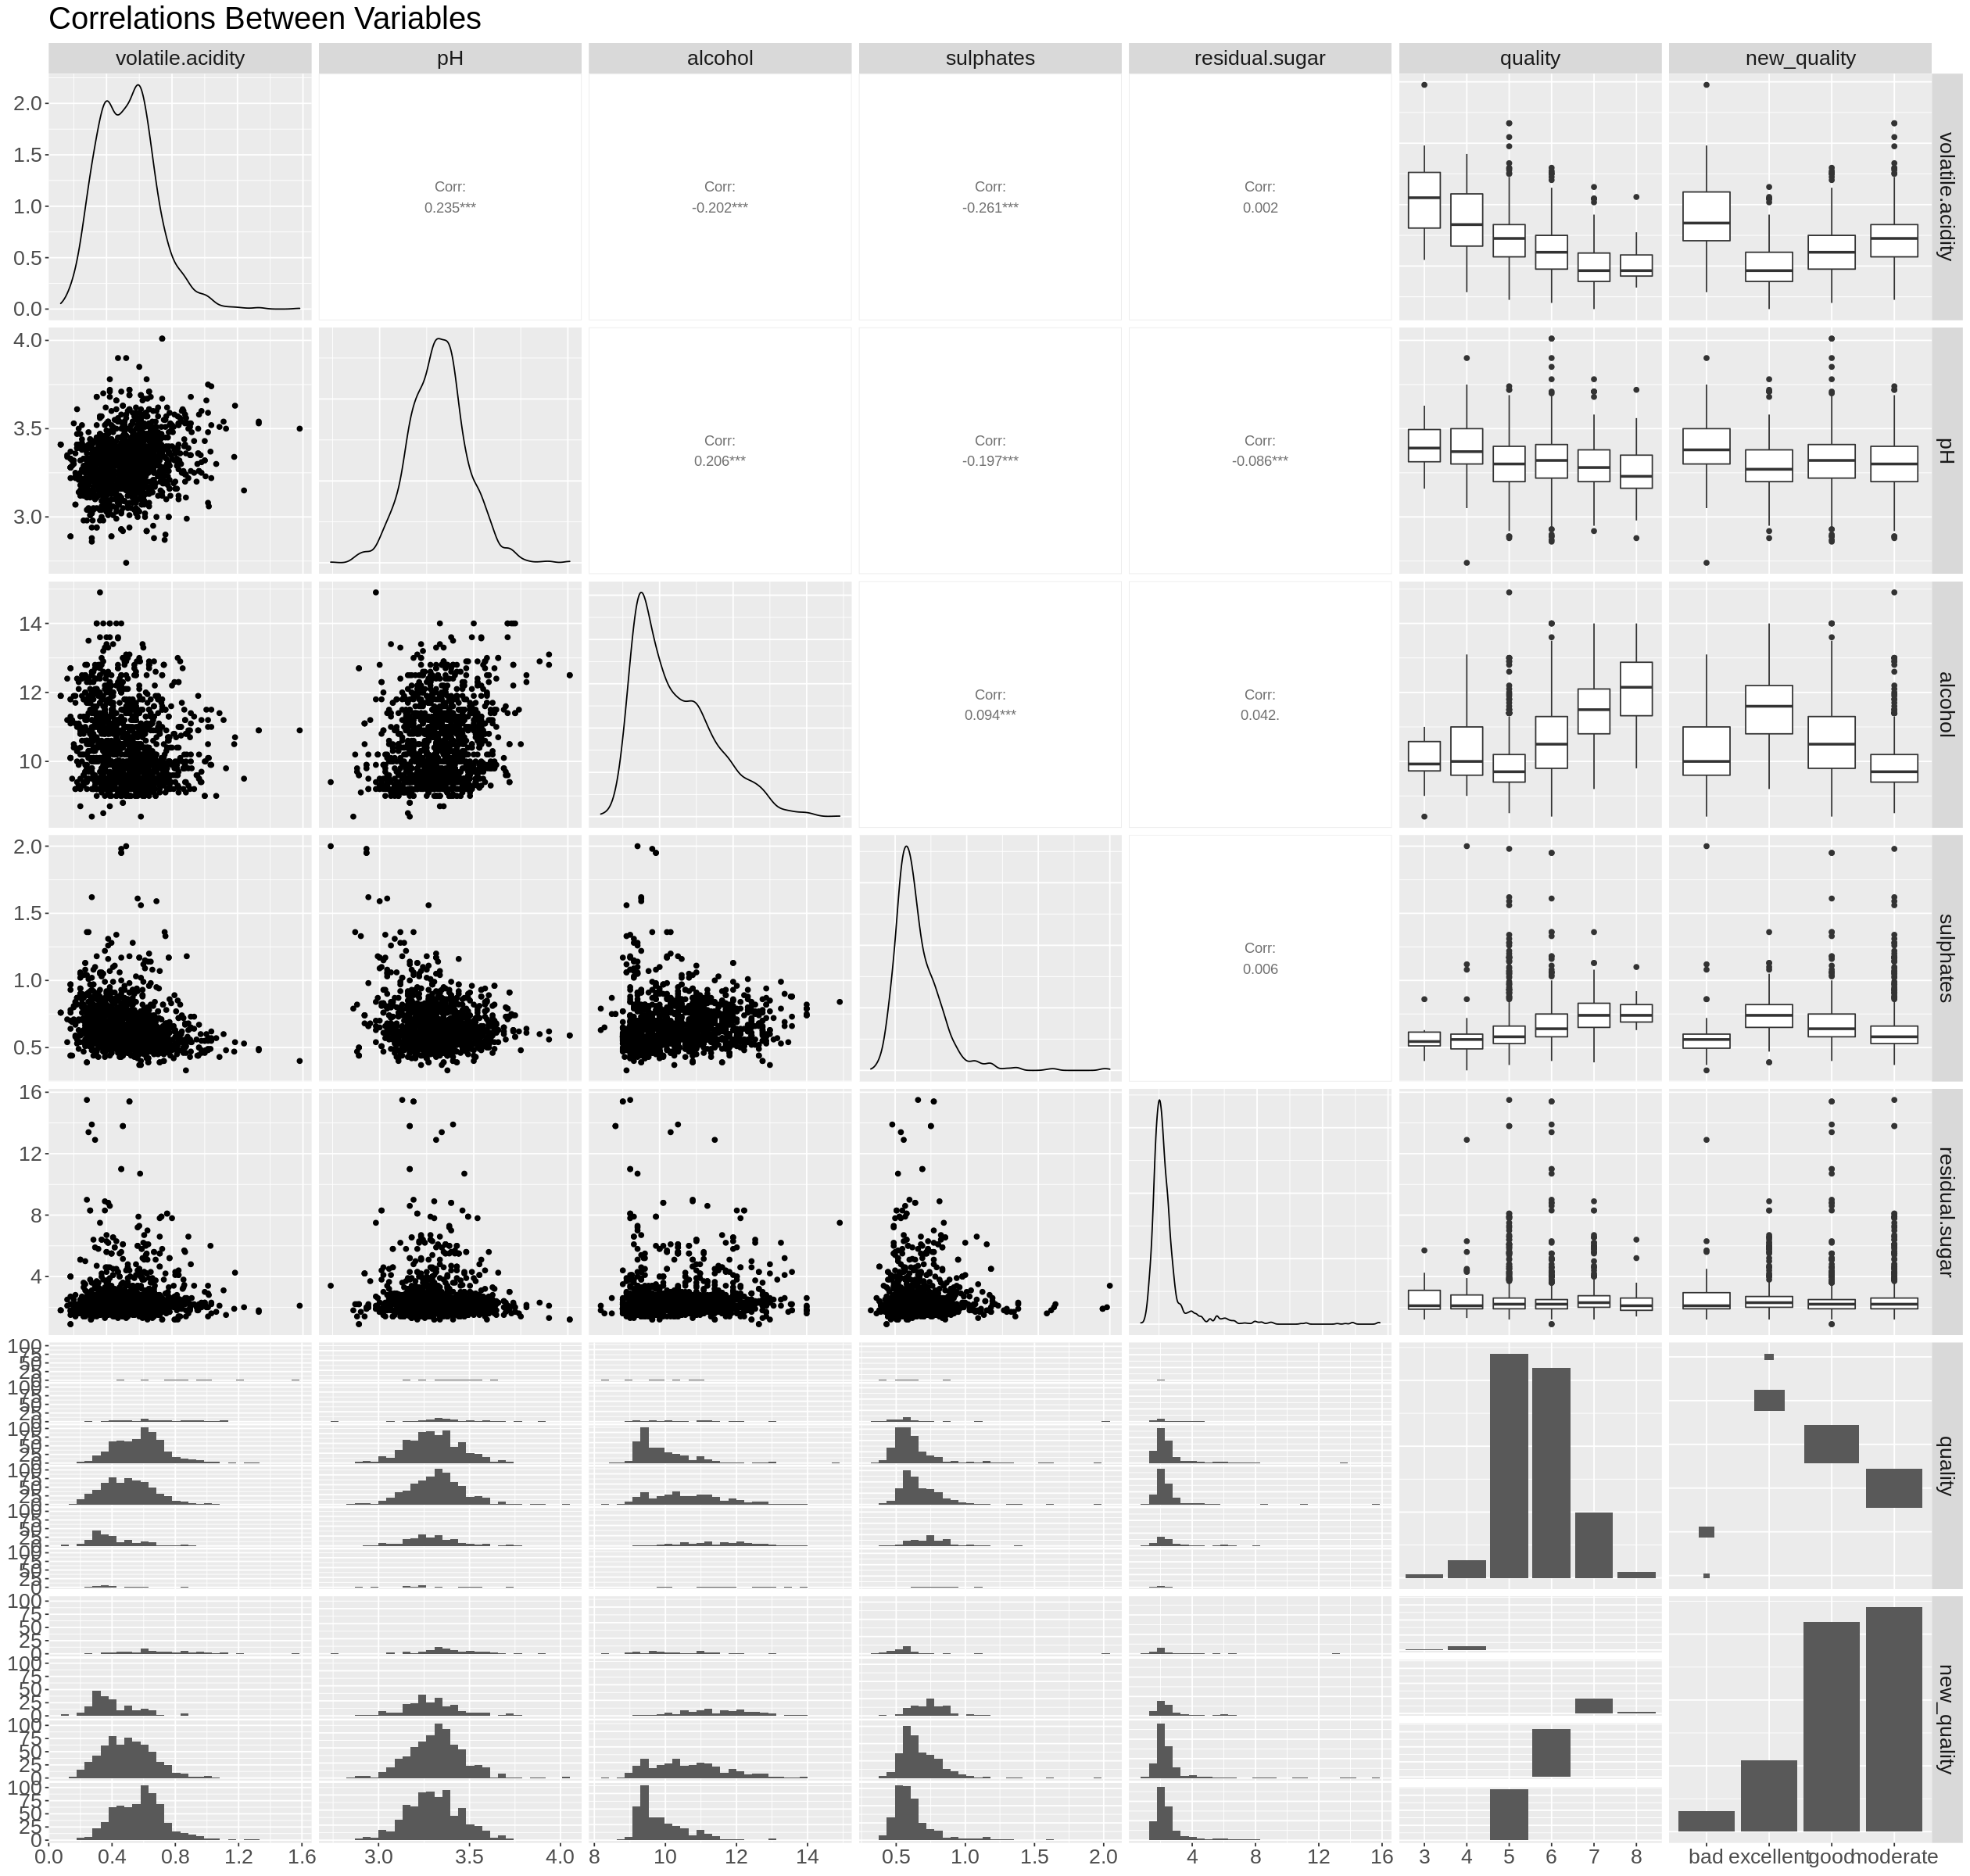

In [19]:
# correlations between variables
library(GGally)
options(repr.plot.height = 20, repr.plot.width = 21)
wine_quality <- wine_quality_factored |>
    select(volatile.acidity:new_quality)
wine_pairs <- ggpairs(wine_quality) +
                ggtitle("Correlations Between Variables") +
                theme(text = element_text(size = 20))
wine_pairs

In [47]:
wine_quality_new <-wine_quality|>
    select(-quality)|>
    mutate(new_quality = as.factor(new_quality))
wine_quality_new


data_split <- initial_split(wine_quality_new, prop = 0.75, strata = new_quality) 
data_train <- training(data_split)
data_test <- testing(data_split)

volatile.acidity,pH,alcohol,sulphates,residual.sugar,new_quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.580,3.25,9.0,0.57,2.20,bad
0.610,3.16,8.4,0.63,2.10,bad
1.185,3.63,10.7,0.54,4.25,bad
⋮,⋮,⋮,⋮,⋮,⋮
0.33,3.23,10.0,1.10,1.7,good
0.38,3.23,11.3,0.76,2.0,good
0.36,3.24,11.4,0.70,1.8,good


In [65]:
my_recipe <- recipe(new_quality ~ . , data = data_train) |> 
    step_scale(all_predictors()) |> 
    step_center(all_predictors()) |>
    step_upsample(new_quality, over_ratio = 1, skip = TRUE)
   

# specification
knn_spec <- nearest_neighbor(weight_func = "gaussian", neighbors = tune()) |> 
    set_engine("kknn") |>
    set_mode("classification")

# vfold
my_vfold <- vfold_cv(data_train, v = 5, strata = new_quality)

# k_values
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

# k validations
knn_fit <- workflow() |>
    add_recipe(my_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = my_vfold, grid = k_vals) |>
    collect_metrics()

knn_fit

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8364947,5,0.009052114,Preprocessor1_Model01
1,roc_auc,hand_till,0.6807514,5,0.008145384,Preprocessor1_Model01
6,accuracy,multiclass,0.7556051,5,0.017707940,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
91,roc_auc,hand_till,0.8190060,5,0.022347821,Preprocessor1_Model19
96,accuracy,multiclass,0.5830025,5,0.006139318,Preprocessor1_Model20
96,roc_auc,hand_till,0.8189930,5,0.022732658,Preprocessor1_Model20


In [66]:
df_knn_fit <- knn_fit |>
    arrange(desc(mean))
    
 df_knn_fit[ df_knn_fit$.metric == "accuracy", ]

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8364947,5,0.009052114,Preprocessor1_Model01
6,accuracy,multiclass,0.7556051,5,0.017707940,Preprocessor1_Model02
11,accuracy,multiclass,0.6888717,5,0.010356499,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
91,accuracy,multiclass,0.5863255,5,0.005702181,Preprocessor1_Model19
86,accuracy,multiclass,0.5846588,5,0.008924950,Preprocessor1_Model18
96,accuracy,multiclass,0.5830025,5,0.006139318,Preprocessor1_Model20


In [67]:
knn_spec2 <- nearest_neighbor(weight_func = "gaussian", neighbors =1) |>
set_engine("kknn") |>
set_mode("classification")
#creating second specification with neighbors value decided from above

knn_fit2 <- workflow() |>
add_recipe(my_recipe) |>
add_model(knn_spec2) |>
fit(data = data_train)
knn_fit2

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_scale()
• step_center()
• step_upsample()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(1,     data, 5), kernel = ~"gaussian")

Type of response variable: nominal
Minimal misclassification: 0.03063973
Best kernel: gaussian
Best k: 1

In [68]:
#testing classifier on test data set
#testing the accuracy of the model on the test data set
data_test_predictions <- predict(knn_fit2, data_test) |>
    bind_cols(data_test) 
data_test_predictions

.pred_class,volatile.acidity,pH,alcohol,sulphates,residual.sugar,new_quality
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
moderate,0.610,3.16,8.40,0.63,2.1,bad
moderate,0.815,3.32,9.80,0.51,1.2,bad
bad,0.760,3.55,9.95,0.63,1.8,bad
⋮,⋮,⋮,⋮,⋮,⋮,⋮
good,0.42,3.72,14.0,0.74,2.0,good
good,0.26,2.98,11.8,0.63,1.9,good
moderate,0.33,3.23,10.0,1.10,1.7,good


In [52]:
glimpse(data_test_predictions)

Rows: 400
Columns: 7
$ .pred_class      <fct> moderate, moderate, moderate, moderate, moderate, mod…
$ volatile.acidity <dbl> 0.610, 0.815, 0.760, 0.590, 0.610, 0.635, 0.870, 0.91…
$ pH               <dbl> 3.16, 3.32, 3.55, 3.38, 3.26, 3.31, 3.60, 3.26, 3.41,…
$ alcohol          <dbl> 8.40, 9.80, 9.95, 9.00, 9.30, 10.40, 9.80, 10.00, 11.…
$ sulphates        <dbl> 0.63, 0.51, 0.63, 0.50, 0.51, 0.57, 0.72, 0.47, 0.57,…
$ residual.sugar   <dbl> 2.1, 1.2, 1.8, 4.4, 2.8, 2.0, 3.3, 2.1, 4.4, 1.6, 3.1…
$ new_quality      <fct> bad, bad, bad, bad, bad, bad, bad, bad, bad, bad, bad…


In [54]:
write_csv(data_test_predictions, "test_predictions.csv")

In [69]:
# Compare the accuracy of predictions to the true values in the test set
accuracies <- data_test_predictions |> 
    metrics(truth = new_quality, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)
accuracies

# Compare the predictions to the true values in a confusion matrix
wine_cm <- data_test_predictions |> 
    conf_mat(truth = new_quality, estimate = .pred_class)
wine_cm

.metric,.estimate
<chr>,<dbl>
accuracy,0.7975


          Truth
Prediction bad good moderate
  bad        5    0        9
  good       0   28       34
  moderate  13   25      286